# SN2023ixf with J-VAR (v2)

In this Jupyter notebook, we will create the necessary code to study SN2023ixf as collected in J-VAR.

In [1]:
# Ejecution Time
import time
a = time.time()

# Packages
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table, Column, vstack, join
from astropy.time import Time
from collections import defaultdict
from datetime import datetime, timedelta
import glob
import jdcal
from lmfit import Model, Parameters
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import smplotlib
import sncosmo
from tqdm import tqdm as tqdm

J-VAR is a project from OAJ aimed at finding variable sources. To achieve this, they observe a sky field 11 times, taking 3 sets of images with 7 different filters for each field. Instead of pointing at luminous objects, they survey the sky looking for variable or new sources. Therefore, to search for SN2023ixf, we should look in regions near the M101 galaxy, specifically at $\alpha$ = 210.91083$\,$deg and $\delta$ = 54.311694$\,$deg. \
This search will be based on selecting the sky regions within 2$\,$arcsec of the SN2023ixf coordinates. Then, we will examine the magnitude values to see if we have detected the light curve. Note that the magnitudes collected in J-VAR are instrumental magnitudes, that is to say, that are affected by atmosphere extinction. Therefore, we should correct them by doing a match between the J-VAR catalogue and the J-PLUS catalogue to calculate the offset. 

## 1. Data

First, we should estimate the magnitude offset before starting to calculate the light curve. We should download a catalogue (e.g: J-PLUS) to match it with J-VAR catalogues. In this way, we will much just the catalogues and see the offset (difference in magnitude between the stars in J-VAR (`JVAR`) and J-PLUS (`JPLUS`) to know the extinction effect. 

### 1.1. J-VAR

First, we introduce the J-VAR data, from the field in which SN2023ixf is collected, in `JVAR`, including the 7 filters. The last columns will include the name of the filter by using the `extract_filter` function.  

_Data downloaded from the HPC_.

In [2]:
# Paths (concatenate all sets (fields) of data)
base_directory_path = '/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/JVAR/'
file_pattern = base_directory_path + '*/catalogues/*.proccat'
file_list = sorted(glob.glob(file_pattern))

# Filters
filters_JVAR = ['J0395','gSDSS','J0515','rSDSS','J0660','iSDSS','J0861']

filter_mapping = {
    'rSDSS': 1,
    'gSDSS': 2,
    'iSDSS': 3,
    'zSDSS': 4,
    'uJAVA': 5,
    'J0378': 6,
    'J0395': 7,
    'J0410': 8,
    'J0430': 9,
    'J0515': 10,
    'J0660': 11,
    'J0861': 12
}

In [3]:
# Read JVAR02433
JVAR = []

# Identify filter
def extract_filter(file_path):
    for filter_name in filters_JVAR:
        if filter_name in file_path:
            return f'{filter_name}'
    return 'Unknown'
    
# Read each .proccat file and add the filter
for file_path in tqdm(file_list):
    with fits.open(file_path, memmap=True) as hdul:
        
        data = Table(hdul[2].data)
        
        filter_name = extract_filter(file_path)
        data['FILTER'] = filter_name
        
        JVAR.append(data)
        
JVAR = vstack(JVAR)
JVAR[:5]

100%|█████████████████████████████████████████| 474/474 [00:54<00:00,  8.68it/s]


NUMBER,X_IMAGE,Y_IMAGE,THETA_WORLD,ERRTHETA_WORLD,A_IMAGE,B_IMAGE,ERRA_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETA_IMAGE,FLUX_AUTO,FLUXERR_AUTO,ALPHA_J2000,DELTA_J2000,X_WORLD,Y_WORLD,MAG_AUTO,MAG_BEST,MAGERR_AUTO,MAGERR_BEST,FLUX_MAX,FWHM_IMAGE,FLAGS,ELLIPTICITY,MU_THRESHOLD,THRESHOLD,BACKGROUND,FLUX_RADIUS,ISOAREA_IMAGE,CLASS_STAR,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,MU_MAX,KRON_RADIUS,A_WORLD,B_WORLD,ERRA_WORLD,ERRB_WORLD,ISOAREA_WORLD,FLUX_PETRO,FLUXERR_PETRO,PETRO_RADIUS,FWHM_WORLD,XWIN_IMAGE,YWIN_IMAGE,SNR_WIN,FLAGS_WIN,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_WORLD,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,XWIN_WORLD,YWIN_WORLD,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_WORLD,MAG_APER,MAGERR_APER,FLUX_APER,FLUXERR_APER,FLAGS_WEIGHT,OBSDATE,FILTER
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32[20],float32[20],float32[20],float32[20],int16,float64,str5
1,1017.42993,83.22495,71.41145,71.9044,0.7489603,0.45497432,0.21364479,0.124597274,70.85002,71.357,304.94507,60.883694,210.20944925841223,53.40675171997641,210.20944925841223,53.40675171997641,18.789446,18.789446,0.21682492,0.21682492,18.411125,3.4332356,0,0.39252543,21.031239,11.601993,-0.30757487,1.8720715,5,0.35179046,79.113716,19.53169,20.25437,0.26811302,174.90575,43.132248,19.39299,0.26781064,20.56111,7.2445765,0.00011433464,7.0147595e-05,3.261623e-05,1.921395e-05,1.1909388e-07,367.82364,67.65312,7.919999,0.0005298627,1017.467468821414,82.99647957623169,5.94295,0,1.2374558,1.0726498,58.829533,0.38416985,0.37853342,71.67437,210.20945944214725,53.406716749935924,0.00018874131,0.00016525964,5.870979e-05,5.8169844e-05,-87.36581,18.475063 .. 16.459906,0.20933272 .. 0.17816071,407.3566 .. 2606.3818,78.52032 .. 427.58273,0,2022.4350562052882,J0395
2,1623.3173,55.26257,23.30034,25.182444,1.686236,1.619425,0.04748901,0.04424839,29.094828,28.36219,4332.921,115.57611,210.36558224572678,53.4023403477708,210.36558224572678,53.4023403477708,15.908048,15.908048,0.028967908,0.028967908,291.42133,3.1590765,16,0.039621353,21.076591,11.601993,0.15750866,1.9657075,52,0.959158,3883.5745,89.27744,16.02692,0.02496548,4153.355,100.255875,15.954002,0.026214441,17.562508,4.064534,0.00025817726,0.00024893295,7.270866e-06,6.8024797e-06,1.2385764e-06,4460.455,139.32042,5.2799997,0.0004875508,1623.3459166836683,55.37378326359054,46.24608,0,1.1189498,1.0945237,78.373535,0.044463657,0.04359123,72.030495,210.36558945005225,53.402357366648154,0.00017101779,0.00016853145,6.7970377e-06,6.7106926e-06,81.74406,15.97732 .. 15.737788,0.026837993 .. 0.09254236,4065.1094 .. 5068.5615,100.45983 .. 431.91217,0,2022.4350562052882,J0395
3,2293.4565,49.508987,-60.547314,-35.276863,0.8952356,0.88327146,0.1261762,0.12584598,-76.73643,-69.7691,415.1578,66.24735,210.53847359598953,53.40116716957629,210.53847359598953,53.40116716957629,18.454468,18.454468,0.17329465,0.17329465,44.581997,3.0384252,16,0.013364255,21.078901,11.601993,0.18579313,1.6143409,10,0.50947076,266.83005,31.68572,18.934414,0.12896109,384.94193,53.08346,18.536512,0.14975932,19.600912,5.072828,0.00013750857,0.00013558015,1.9429144e-05,1.9269175e-05,2.3818777e-07,455.79913,86.29149,6.5999994,0.0004689303,2293.406077962168,49.51397690299168,9.261206,0,0.90720063,0.88377744,-49.34116,0.20653999,0.20502032,67.00161,210.53846054049842,53.40116796179936,0.00013962356,0.00013538093,3.161139e-05,3.158397e-05,-57.996826,18.458778 .. 17.00939,0.20784378 .. 0.29550138,413.51233 .. 1571.2462,79.13993 .. 427.5372,0,2022.43

### 1.2. J-PLUS

Secondly, we introduce the J-PLUS data from the field in which SN2023ixf is collected in `JPLUS`, including, in this case, 12 filters (7 in common with J-VAR). The parameters for the 12 filters are included as arrays in each column.

_Data downloaded from the OAJ catalogue web using ADQL_.

In [4]:
# Read M101 Tile
JPLUS = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/JPLUS/M101_Tile.fits', format = 'fits')
JPLUS[:5]

NUMBER,TILE_ID,ALPHA_J2000,DELTA_J2000,MAG_AUTO,MAG_ERR_AUTO,MAG_APER_0_8,MAG_ERR_APER_0_8,MAG_APER_1_0,MAG_ERR_APER_1_0,MAG_APER_1_2,MAG_ERR_APER_1_2,MAG_APER_1_5,MAG_ERR_APER_1_5,MAG_APER_2_0,MAG_ERR_APER_2_0,MAG_APER_3_0,MAG_ERR_APER_3_0,MAG_APER_COR_3_0,MAG_ERR_APER_COR_3_0,MAG_APER_4_0,MAG_ERR_APER_4_0,MAG_APER_6_0,MAG_ERR_APER_6_0,MAG_APER_COR_6_0,MAG_ERR_APER_COR_6_0
int32,int32,float64,float64,float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12]
53,94554,211.68999669448039,53.390699374021565,17.243364 .. 16.614517,0.010553191 .. 0.017826112,18.643063 .. 17.998787,0.021934733 .. 0.032140017,18.311821 .. 17.678387,0.01628538 .. 0.024220983,18.059887 .. 17.434763,0.013353017 .. 0.019963257,17.764484 .. 17.149368,0.010602892 .. 0.016268812,17.508167 .. 16.887093,0.008904773 .. 0.013750626,17.359524 .. 16.715746,0.008565149 .. 0.013311599,17.167252 .. 16.511822,0.0077202306 .. 0.011903403,17.300766 .. 16.654886,0.00889649 .. 0.014156518,17.24897 .. 16.61258,0.01033782 .. 0.017246267,17.169075 .. 16.529896,0.009608871 .. 0.01597889
64,94554,212.0389516739895,53.390740201055344,19.213326 .. 19.126139,0.04340559 .. 0.13717492,20.750202 .. 20.857252,0.05917739 .. 0.15493476,20.384068 .. 20.49125,0.047447942 .. 0.12749977,20.123133 .. 20.227343,0.038766824 .. 0.10848084,19.82472 .. 19.910471,0.032090317 .. 0.09211262,19.523336 .. 19.6055,0.028081097 .. 0.08575089,19.336426 .. 19.44516,0.029770933 .. 0.10410715,19.14436 .. 19.240858,0.02683857 .. 0.09304038,19.28186 .. 19.25507,0.03495641 .. 0.11298707,19.229057 .. 19.154747,0.04685153 .. 0.15082614,19.149162 .. 19.072063,0.043538127 .. 0.13969311
105,94554,211.49965363139856,53.3959199435484,18.314419 .. 18.160603,0.021404589 .. 0.06152991,19.78614 .. 19.614151,0.035420287 .. 0.0734913,19.392298 .. 19.204727,0.025960518 .. 0.05414102,19.126278 .. 18.921389,0.021404589 .. 0.044764087,18.876652 .. 18.648596,0.018190587 .. 0.038203545,18.608719 .. 18.360054,0.015498446 .. 0.03339911,18.442913 .. 18.18917,0.015655832 .. 0.036447443,18.250462 .. 17.985226,0.0141151 .. 0.032587327,18.383194 .. 18.131973,0.017279401 .. 0.042709775,18.311016 .. 18.15083,0.02150399 .. 0.061331104,18.231121 .. 18.068146,0.019979825 .. 0.056824874
134,94554,211.83178377555862,53.39440363176192,17.270771 .. 17.166323,0.010147299 .. 0.0282302,18.796818 .. 18.729792,0.022812786 .. 0.04751421,18.386793 .. 18.317081,0.015738668 .. 0.03306777,18.09106 .. 18.017118,0.012947125 .. 0.027169911,17.794855 .. 17.712158,0.010221851 .. 0.02178563,17.553741 .. 17.46331,0.008631417 .. 0.018985804,17.39914 .. 17.311035,0.008262801 .. 0.019366845,17.207031 .. 17.107067,0.007451017 .. 0.017329102,17.339867 .. 17.266226,0.008581716 .. 0.021967867,17.281143 .. 17.181343,0.00986566 .. 0.027136777,17.201248 .. 17.098661,0.009161562 .. 0.025148734
224,94554,210.67109921187384,53.3990564364207,16.616528 .. 16.511274,0.006618524 .. 0.017461639,18.127659 .. 18.050554,0.01489375 .. 0.030267945,17.703596 .. 17.625916,0.0109756505 .. 0.022547713,17.400223 .. 17.31966,0.00878052 .. 0.01817402,17.14682 .. 17.060837,0.007550419 .. 0.015680684,16.914612 .. 16.818815,0.006270617 .. 0.013203914,16.746273 .. 16.6371,0.0057528974 .. 0.01269862,16.551655 .. 16.430614,0.0051771933 .. 0.011331841,16.691978 .. 16.573689,0.005844016 .. 0.013485554,16.63505 .. 16.52227,0.0063741608 .. 0.016161127,16.555155 .. 16.439587,0.005922709 .. 0.014976585


## 2. Offsets

Now, we are prepared to calculate the offset of the instrumental magnitudes of `JVAR`. The offset is defined as the difference between the tabulated magnitudes, collected in `JPLUS`, and the observed one, collected in `JVAR`. Therefore, the apparent magnitudes in the AB system needed for the curve light are obtained by adding up the offset to the instrumental magnitude collected in `JVAR`.

### 2.1. Match between J-VAR and J-PLUS

Then, we will match the J-PLUS filtered (`JPLUS`) and J-VAR filtered (`JVAR`) catalogues to calculate the offset associated with the instrumental magnitudes.

In [5]:
# Convert JPLUS coordinates to SkyCoord
coords_JPLUS = SkyCoord(ra=JPLUS['ALPHA_J2000']*u.deg, dec=JPLUS['DELTA_J2000']*u.deg)

# Convert JVAR coordinates to SkyCoord
coords_JVAR = SkyCoord(ra=JVAR['ALPHA_J2000']*u.deg, dec=JVAR['DELTA_J2000']*u.deg)

In [6]:
# Cross-match with a given radius
radius = 1.0 * u.arcsec  # Define the matching radius

# Match JPLUS coordinates to JVAR coordinates
idx_JVAR, sep2d, _ = coords_JVAR.match_to_catalog_sky(coords_JPLUS)

# Filter matches within the specified radius
matches = sep2d < radius
matched_JPLUS = JPLUS[idx_JVAR[matches]]
matched_JVAR = JVAR[matches]

In [7]:
# Create a new table with matched results
matched_table = Table()

matched_table['ALPHA_J2000'] = JVAR['ALPHA_J2000'][matches]
matched_table['DELTA_J2000'] = JVAR['DELTA_J2000'][matches]
matched_table['OBSDATE'] = JVAR['OBSDATE'][matches]
matched_table['FILTER_JVAR'] = JVAR['FILTER'][matches]
matched_table['MAG_APER_JVAR'] = JVAR['MAG_APER'][matches]
matched_table['MAGERR_APER_JVAR'] = JVAR['MAGERR_APER'][matches]

mag_columns_jplus = [col for col in JPLUS.columns if col.startswith('MAG_')]
for col in mag_columns_jplus:
    if col in JPLUS.columns:
        matched_table[col + '_JPLUS'] = JPLUS[col][idx_JVAR[matches]]

matched_table.remove_column('MAG_AUTO_JPLUS'); matched_table.remove_column('MAG_ERR_AUTO_JPLUS')
matched_table[:5]

ALPHA_J2000,DELTA_J2000,OBSDATE,FILTER_JVAR,MAG_APER_JVAR,MAGERR_APER_JVAR,MAG_APER_0_8_JPLUS,MAG_ERR_APER_0_8_JPLUS,MAG_APER_1_0_JPLUS,MAG_ERR_APER_1_0_JPLUS,MAG_APER_1_2_JPLUS,MAG_ERR_APER_1_2_JPLUS,MAG_APER_1_5_JPLUS,MAG_ERR_APER_1_5_JPLUS,MAG_APER_2_0_JPLUS,MAG_ERR_APER_2_0_JPLUS,MAG_APER_3_0_JPLUS,MAG_ERR_APER_3_0_JPLUS,MAG_APER_COR_3_0_JPLUS,MAG_ERR_APER_COR_3_0_JPLUS,MAG_APER_4_0_JPLUS,MAG_ERR_APER_4_0_JPLUS,MAG_APER_6_0_JPLUS,MAG_ERR_APER_6_0_JPLUS,MAG_APER_COR_6_0_JPLUS,MAG_ERR_APER_COR_6_0_JPLUS
float64,float64,float64,str5,float32[20],float32[20],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12]
210.53847359598953,53.40116716957629,2022.4350562052882,J0395,18.458778 .. 17.00939,0.20784378 .. 0.29550138,16.772243 .. 16.579084,0.008453322 .. 0.015788369,16.436338 .. 16.254992,0.006651658 .. 0.012499816,16.18244 .. 16.01123,0.005359431 .. 0.01017215,15.844063 .. 15.686767,0.0040278565 .. 0.0077740736,15.577466 .. 15.427343,0.003309262 .. 0.0065232636,15.42432 .. 15.264518,0.002988276 .. 0.0059517017,15.229203 .. 15.057316,0.0026879988 .. 0.005305588,15.3639 .. 15.199716,0.002922008 .. 0.0059392764,15.309306 .. 15.142628,0.0029613546 .. 0.0063244593,15.229412 .. 15.059944,0.002752196 .. 0.005860583
210.6712367181428,53.39887547197032,2022.4350562052882,J0395,19.052786 .. 16.948,0.35402757 .. 0.27900153,18.127659 .. 18.050554,0.01489375 .. 0.030267945,17.703596 .. 17.625916,0.0109756505 .. 0.022547713,17.400223 .. 17.31966,0.00878052 .. 0.01817402,17.14682 .. 17.060837,0.007550419 .. 0.015680684,16.914612 .. 16.818815,0.006270617 .. 0.013203914,16.746273 .. 16.6371,0.0057528974 .. 0.01269862,16.551655 .. 16.430614,0.0051771933 .. 0.011331841,16.691978 .. 16.573689,0.005844016 .. 0.013485554,16.63505 .. 16.52227,0.0063741608 .. 0.016161127,16.555155 .. 16.439587,0.005922709 .. 0.014976585
211.70262182540586,54.745038174231986,2022.4350562052882,J0395,16.381144 .. 15.984463,0.03607032 .. 0.115599096,15.078001 .. 14.948775,0.0035743343 .. 0.006792478,14.651885 .. 14.535823,0.0026445105 .. 0.0050073816,14.333211 .. 14.233737,0.0021537126 .. 0.004094125,14.082538 .. 14.009552,0.0017778482 .. 0.003458365,13.8506365 .. 13.807483,0.0014620394 .. 0.0029282207,13.675137 .. 13.641813,0.0012891211 .. 0.0026196598,13.478851 .. 13.433166,0.0011576205 .. 0.0023338788,13.61318 .. 13.577852,0.0012456328 .. 0.0025492501,13.556263 .. 13.518669,0.0012166405 .. 0.0025264705,13.476369 .. 13.435986,0.0011306991 .. 0.0023421624
211.56158074846334,54.74558097713312,2022.4350562052882,J0395,18.27933 .. 17.576626,0.17642309 .. 0.49744284,16.492958 .. 16.387196,0.007583553 .. 0.014703229,16.230736 .. 16.129927,0.006129797 .. 0.011969672,15.977828 .. 15.882605,0.0048624203 .. 0.00955917,15.641626 .. 15.552324,0.0035722635 .. 0.0070865424,15.358194 .. 15.2744875,0.0029012992 .. 0.0057984567,15.233149 .. 15.153751,0.0026921406 .. 0.0055085337,15.037561 .. 14.945408,0.0024187847 .. 0.0049038376,15.168684 .. 15.0844345,0.002617589 .. 0.0054464075,15.113654 .. 15.030265,0.0026196598 .. 0.0057446137,15.033758 .. 14.947581,0.0024353517 .. 0.005322155
210.57131784527925,54.74119672426237,2022.4350562052882,J0395,17.516134 .. 17.230825,0.09032124 .. 0.3615714,15.793706 .. 15.720307,0.0052641705 .. 0.010536624,15.485539 .. 15.406595,0.004116904 .. 0.0082131,15.2694645 .. 15.187969,0.00337553 .. 0.0067262095,14.972357 .. 14.886084,0.0026569357 .. 0.005255887,14.712637 .. 14.629095,0.0021744212 .. 0.004295,14.556816 .. 14.490763,0.0019507665 .. 0.003969872,14.3611965 .. 14.284565,0.0017529977 .. 0.0035432712,14.497589 .. 14.423511,0.0018896756 .. 0.0038704698,14.443084 .. 14.366373,0.0018668959 .. 0.0039429506,14.363189 .. 14.2836895,0.0017343598 .. 0.0036530276


### 2.2. Offset calculation

The offset is defined as the difference between the tabulated magnitudes, collected in `JPLUS`, and the observed one, collected in `JVAR`. 

The parameter `growth_curve` is the index for which `matched_table['MAG_APER_JVAR'][i][growth_curve]` returns the magnitude for an approximately aperture of 6 arcsec, to be in concordance with `matched_table['MAG_APER_COR_6_0_JPLUS'][i]` (magnitude for an aperture of 6 arcsec) when calculating the offsets. Note that the SN2023ixf data points must be omitted for this process. 

In [8]:
# Remove all data of SN2023ixf from JVAR (to avoid wrong offsets)
alpha_min = 210.91 - 0.3
alpha_max = 210.91 + 0.3
delta_min = 54.31 - 0.2
delta_max = 54.31 + 0.2

mask = ~((matched_table['ALPHA_J2000'] >= alpha_min) & 
         (matched_table['ALPHA_J2000'] <= alpha_max) &
         (matched_table['DELTA_J2000'] >= delta_min) &
         (matched_table['DELTA_J2000'] <= delta_max))

matched_table_maskSN = matched_table[mask]

In [9]:
# Offset calculation
growth_curve = 8 # index of the maximum of the growth curve
offsets_by_obsdate_filter = defaultdict(lambda: defaultdict(list))

for i in tqdm(range(len(matched_table_maskSN['OBSDATE']))):
    
    filter_name = matched_table_maskSN['FILTER_JVAR'][i]
    filter_number = filter_mapping[filter_name] - 1  # subtract 1 because the index in the table is 0 based
    
    offset = matched_table_maskSN['MAG_APER_JVAR'][i][growth_curve] - matched_table_maskSN['MAG_APER_COR_6_0_JPLUS'][i][filter_number] # using 6 arcsec growth curve criteria
    obsdate = matched_table_maskSN['OBSDATE'][i]
    
    offsets_by_obsdate_filter[obsdate][filter_name].append(offset)

100%|███████████████████████████████| 522842/522842 [00:03<00:00, 163124.10it/s]


In [10]:
# Calculate the median of the offsets for each OBSDATE and FILTER_JVAR
median_offsets = {
    obsdate: {filter_name: np.median(offsets) for filter_name, offsets in filters.items()}
    for obsdate, filters in offsets_by_obsdate_filter.items()
}

# Create lists for OBSDATE and offset columns
obsdate_unique = list(median_offsets.keys())
column_data = defaultdict(list)

# Fill data for each filter column
for obsdate in obsdate_unique:
    for filter_name in filter_mapping.keys():
        column_name = f'OFFSET_{filter_name}'
        column_data[column_name].append(median_offsets[obsdate].get(filter_name, np.nan))

# # Create the table with the offsets per obsdate and filter
columns = [obsdate_unique] + [column_data[f'OFFSET_{filter_name}'] for filter_name in filter_mapping.keys()]
column_names = ['OBSDATE'] + [f'OFFSET_{filter_name}' for filter_name in filter_mapping.keys()]

offsets_table = Table(columns, names=column_names)
offsets_table[0:5]

OBSDATE,OFFSET_rSDSS,OFFSET_gSDSS,OFFSET_iSDSS,OFFSET_zSDSS,OFFSET_uJAVA,OFFSET_J0378,OFFSET_J0395,OFFSET_J0410,OFFSET_J0430,OFFSET_J0515,OFFSET_J0660,OFFSET_J0861
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2022.4350562052882,nan,nan,nan,nan,nan,nan,1.6132164001464844,nan,nan,nan,nan,nan
2022.4350801606904,nan,nan,nan,nan,nan,nan,-0.2257213592529297,nan,nan,nan,nan,nan
2022.43510425045,nan,nan,nan,nan,nan,nan,-0.2157917022705078,nan,nan,nan,nan,nan
2023.1256165394072,nan,nan,nan,nan,nan,nan,0.9905247688293457,nan,nan,nan,nan,nan
2023.125641048527,nan,nan,nan,nan,nan,nan,1.364579200744629,nan,nan,nan,nan,nan


## 3. SN2023ixf sample selection

In this section, we have to filter the `JVAR` data to select the region where SN2023ixf is. In this way, we could do the match later to represent the light curve correctly. The sample selection will be saved in `JVAR_SN`.

### 3.1. J-VAR selection

We filter the `JVAR` data to select the SN2023ixf region and save the result in `SN2023ixf`.

In [11]:
# SN2023ixf coordinates
alpha_target = 210.91075
delta_target = 54.3116944

# Limit in arcsec for search
limit_distance = 4 / 3600  

# Sky detected values
alpha_values = JVAR['ALPHA_J2000']
delta_values = JVAR['DELTA_J2000']

# Distances (spherical distance)
distances = np.arccos(np.sin(delta_target)*np.sin(delta_values) + np.cos(delta_target)*np.cos(delta_values)*np.cos(alpha_target-alpha_values))
        
# Select nearest rows (index)
close_rows = JVAR[distances <= limit_distance]
SN2023ixf = vstack(close_rows)

# Match between selected rows and offsets
SN2023ixf = join(SN2023ixf, offsets_table, keys='OBSDATE')
SN2023ixf

NUMBER,X_IMAGE,Y_IMAGE,THETA_WORLD,ERRTHETA_WORLD,A_IMAGE,B_IMAGE,ERRA_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETA_IMAGE,FLUX_AUTO,FLUXERR_AUTO,ALPHA_J2000,DELTA_J2000,X_WORLD,Y_WORLD,MAG_AUTO,MAG_BEST,MAGERR_AUTO,MAGERR_BEST,FLUX_MAX,FWHM_IMAGE,FLAGS,ELLIPTICITY,MU_THRESHOLD,THRESHOLD,BACKGROUND,FLUX_RADIUS,ISOAREA_IMAGE,CLASS_STAR,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,MU_MAX,KRON_RADIUS,A_WORLD,B_WORLD,ERRA_WORLD,ERRB_WORLD,ISOAREA_WORLD,FLUX_PETRO,FLUXERR_PETRO,PETRO_RADIUS,FWHM_WORLD,XWIN_IMAGE,YWIN_IMAGE,SNR_WIN,FLAGS_WIN,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_WORLD,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,XWIN_WORLD,YWIN_WORLD,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_WORLD,MAG_APER,MAGERR_APER,FLUX_APER,FLUXERR_APER,FLAGS_WEIGHT,OBSDATE,FILTER,OFFSET_rSDSS,OFFSET_gSDSS,OFFSET_iSDSS,OFFSET_zSDSS,OFFSET_uJAVA,OFFSET_J0378,OFFSET_J0395,OFFSET_J0410,OFFSET_J0430,OFFSET_J0515,OFFSET_J0660,OFFSET_J0861
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32[20],float32[20],float32[20],float32[20],int16,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1022,3702.3433,5982.217,-78.364075,-84.600174,2.7412438,2.588796,0.006755751,0.006194819,-77.84725,-84.100914,286497.97,556.28064,210.91068998713968,54.31166376710572,210.91068998713968,54.31166376710572,11.357196,11.357196,0.0021086389,0.0021086389,28786.17,2.4562366,0,0.055612683,21.987368,5.9748387,1.7524465,1.6499028,885,0.9217739,296168.25,577.271,11.321154,0.0021167572,297522.2,578.9887,11.316201,0.0021133944,12.575851,3.5,0.00042380748,0.0004004749,1.0445309e-06,9.582515e-07,2.1079617e-05,286497.97,556.28064,3.5,0.00037907917,3702.360278558167,5982.143420670531,431.00912,0,0.91495746,0.89841026,-72.62128,0.0037161103,0.0036718696,-76.62103,210.9106944085629,54.31165243806059,0.00014145579,0.00013897894,5.745478e-07,5.6799286e-07,-77.87871,11.431035 .. 11.317674,0.002194168 .. 0.0021564201,267661.5 .. 297119.12,540.7867 .. 589.97577,0,2023.3851657606092,J0395,nan,nan,nan,nan,nan,nan,0.15869379043579102,nan,nan,nan,nan,nan
1412,3702.0598,5982.555,-86.33473,88.70371,2.7931235,2.5961962,0.006697636,0.0059900614,-85.80444,89.185104,324884.62,594.03345,210.9106815497683,54.31167604727501,210.9106815497683,54.31167604727501,11.220677,11.220677,0.0019856906,0.0019856906,37380.363,2.2864873,2,0.07050431,22.009382,7.248992,4.428904,1.5006704,900,0.9971096,337249.53,622.0314,11.180121,0.0020030453,338933.0,624.47516,11.174715,0.0020009265,12.292202,3.5,0.000431845,0.00040156257,1.0356056e-06,9.264189e-07,2.14369e-05,324884.62,594.03345,3.5,0.0003528812,3702.0660556554944,5982.46104810021,459.4415,0,0.83627385,0.81346613,87.58734,0.0032452447,0.0031595058,85.707466,210.91068306399063,54.31166146100219,0.00012930736,0.00012580986,5.0180734e-07,4.8862887e-07,84.76265,11.288798 .. 11.180561,0.0020512722 .. 0.0020328267,305127.12 .. 337113.03,576.33405 .. 631.02423,0,2023.3851701852802,J0515,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.2696342468261719,nan,nan
2882,3701.811,5982.843,-73.501976,-73.35564,4.5091343,3.741665,0.011924977,0.009142374,-73.15749,-73.027725,832876.8,1029.1699,210.91070089408436,54.31170889541022,210.91070089408436,54.31170889541022,10.198548,10.140059,0.0013419494,0.0015481474,63470.152,3.8242896,7,0.17020327,21.401438,23.744135,27.814196,1.5753666,1526,0.9323057,867055.0,1215.3505,10.154883,0.0015222456,878974.7,1253.0225,10.140059,0.0015481474,11.717387,3.5,0.00069693086,0.

### 3.2. Offset correction

Finally, to be prepared to plot the light curve, we correct the offset of the magnitudes collected in `JVAR_SN`.

In [12]:
# Offset correction ==> magnitude to use in the light curve plot
for filt in filters_JVAR:
    mag_column_name = f'MAG_{filt}'
    err_column_name = f'MAGERR_{filt}'
    offset_column = f'OFFSET_{filt}'

    if offset_column in SN2023ixf.colnames:
        # create new columns to add results
        mag_col = Column(name=mag_column_name, dtype=float, length=len(SN2023ixf))
        err_col = Column(name=err_column_name, dtype=float, length=len(SN2023ixf))

        # iteraction per row
        for i in range(len(SN2023ixf)):
            if SN2023ixf['FILTER'][i] == filt:
                # Calcualte corrected (by offset) magnitude)
                mag_col[i] = SN2023ixf['MAG_APER'][i][growth_curve] - SN2023ixf[offset_column][i]
                err_col[i] = SN2023ixf['MAGERR_APER'][i][growth_curve]  # Asumimos que el error se calcula de forma similar
            else:
                # Assign if not recognize filter
                mag_col[i] = None
                err_col[i] = None

        SN2023ixf.add_column(mag_col)
        SN2023ixf.add_column(err_col)
    else:
        print(f'Column {offset_column} not found in Table')

SN2023ixf

NUMBER,X_IMAGE,Y_IMAGE,THETA_WORLD,ERRTHETA_WORLD,A_IMAGE,B_IMAGE,ERRA_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETA_IMAGE,FLUX_AUTO,FLUXERR_AUTO,ALPHA_J2000,DELTA_J2000,X_WORLD,Y_WORLD,MAG_AUTO,MAG_BEST,MAGERR_AUTO,MAGERR_BEST,FLUX_MAX,FWHM_IMAGE,FLAGS,ELLIPTICITY,MU_THRESHOLD,THRESHOLD,BACKGROUND,FLUX_RADIUS,ISOAREA_IMAGE,CLASS_STAR,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_ISOCOR,FLUXERR_ISOCOR,MAG_ISOCOR,MAGERR_ISOCOR,MU_MAX,KRON_RADIUS,A_WORLD,B_WORLD,ERRA_WORLD,ERRB_WORLD,ISOAREA_WORLD,FLUX_PETRO,FLUXERR_PETRO,PETRO_RADIUS,FWHM_WORLD,XWIN_IMAGE,YWIN_IMAGE,SNR_WIN,FLAGS_WIN,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_WORLD,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,XWIN_WORLD,YWIN_WORLD,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_WORLD,MAG_APER,MAGERR_APER,FLUX_APER,FLUXERR_APER,FLAGS_WEIGHT,OBSDATE,FILTER,OFFSET_rSDSS,OFFSET_gSDSS,OFFSET_iSDSS,OFFSET_zSDSS,OFFSET_uJAVA,OFFSET_J0378,OFFSET_J0395,OFFSET_J0410,OFFSET_J0430,OFFSET_J0515,OFFSET_J0660,OFFSET_J0861,MAG_J0395,MAGERR_J0395,MAG_gSDSS,MAGERR_gSDSS,MAG_J0515,MAGERR_J0515,MAG_rSDSS,MAGERR_rSDSS,MAG_J0660,MAGERR_J0660,MAG_iSDSS,MAGERR_iSDSS,MAG_J0861,MAGERR_J0861
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,int16,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32[20],float32[20],float32[20],float32[20],int16,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1022,3702.3433,5982.217,-78.364075,-84.600174,2.7412438,2.588796,0.006755751,0.006194819,-77.84725,-84.100914,286497.97,556.28064,210.91068998713968,54.31166376710572,210.91068998713968,54.31166376710572,11.357196,11.357196,0.0021086389,0.0021086389,28786.17,2.4562366,0,0.055612683,21.987368,5.9748387,1.7524465,1.6499028,885,0.9217739,296168.25,577.271,11.321154,0.0021167572,297522.2,578.9887,11.316201,0.0021133944,12.575851,3.5,0.00042380748,0.0004004749,1.0445309e-06,9.582515e-07,2.1079617e-05,286497.97,556.28064,3.5,0.00037907917,3702.360278558167,5982.143420670531,431.00912,0,0.91495746,0.89841026,-72.62128,0.0037161103,0.0036718696,-76.62103,210.9106944085629,54.31165243806059,0.00014145579,0.00013897894,5.745478e-07,5.6799286e-07,-77.87871,11.431035 .. 11.317674,0.002194168 .. 0.0021564201,267661.5 .. 297119.12,540.7867 .. 589.97577,0,2023.3851657606092,J0395,nan,nan,nan,nan,nan,nan,0.15869379043579102,nan,nan,nan,nan,nan,11.192419528961182,0.0021096873097121716,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1412,3702.0598,5982.555,-86.33473,88.70371,2.7931235,2.5961962,0.006697636,0.0059900614,-85.80444,89.185104,324884.62,594.03345,210.9106815497683,54.31167604727501,210.9106815497683,54.31167604727501,11.220677,11.220677,0.0019856906,0.0019856906,37380.363,2.2864873,2,0.07050431,22.009382,7.248992,4.428904,1.5006704,900,0.9971096,337249.53,622.0314,11.180121,0.0020030453,338933.0,624.47516,11.174715,0.0020009265,12.292202,3.5,0.000431845,0.00040156257,1.0356056e-06,9.264189e-07,2.14369e-05,324884.62,594.03345,3.5,0.0003528812,3702.0660556554944,5982.46104810021,459.4415,0,0.83627385,0.81346613,87.58734,0.0032452447,0.0031595058,85.707466,210.91068306399063,54.31166146100219,0.00012930736,0.00012580986,5.0180734e-07,4.8862887e-07,84.76265,11.288798 .. 11.180561,0.0020512722 .. 0.0020328267,305127.12 .. 337113.03,576.33405 .. 631.02423,0,2023.3851701852802,J0515,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.2696342468261719,nan,nan,nan,nan,nan,nan,11.48416519165039,0.0019881457556039095,nan,nan,nan,nan,nan,nan,nan,nan

## 3. Light curve

Lastly, we are now prepared to plot the light curve for the different filters. Then, we will fit them and obtain their characteristical parameters. 

### 4.1. Plot 

We plot the magnitudes vs time diagrama (light curve) using `JVAR` data.

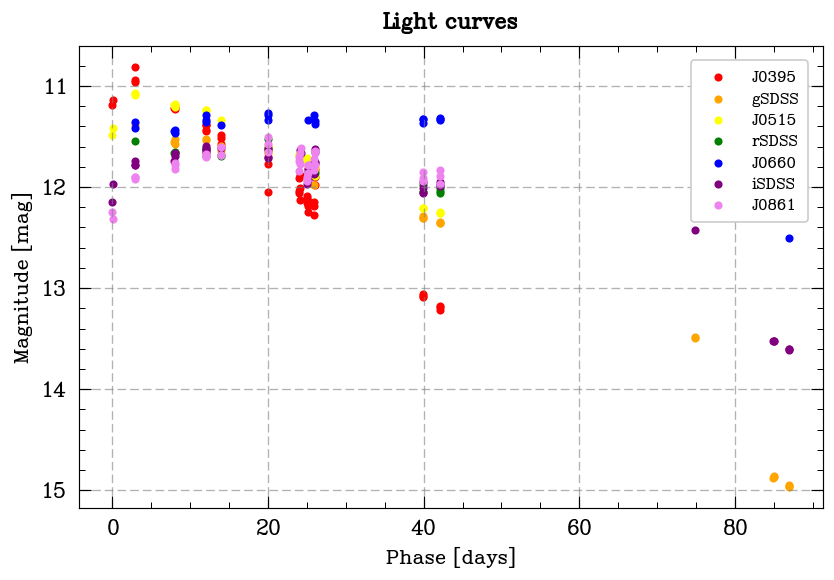

In [13]:
# Light Curve Plot
plt.figure(figsize=(8, 5))

# Color Dictionary
color_dict = {
    'J0395': 'red',
    'gSDSS': 'orange',
    'J0515': 'yellow',
    'rSDSS': 'green',
    'J0660': 'blue',
    'iSDSS': 'purple',
    'J0861': 'violet'
}

# Plot loop
for filt in filters_JVAR:
    mag_column = f'MAG_{filt}'
    magerr_column = f'MAGERR_{filt}'
    year_column = 'OBSDATE'

    
    if mag_column in SN2023ixf.colnames and magerr_column in SN2023ixf.colnames and year_column in SN2023ixf.colnames:
        # Extract data (magnitudes, erros of mangitudes and date)
        mag = SN2023ixf[mag_column]
        e_mag = SN2023ixf[magerr_column]
        years = SN2023ixf[year_column]
        
        # Convert decimal years to days since the first record
        days_since_start = (years - years[0]) * 365.25  
        
        # Plot
        plt.scatter(days_since_start, mag, s=15, color=color_dict[filt], label=filt)
        
# Plot Configuration
plt.xlabel('Phase [days]', fontsize=14)
plt.ylabel('Magnitude [mag]', fontsize=14)
plt.title('Light curves', fontsize=16, fontweight='bold')
plt.grid(True)
plt.gca().invert_yaxis() 
plt.legend(fontsize=11, frameon=True)

plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/light_curve_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

We make the same plot but for all the filters separated. 

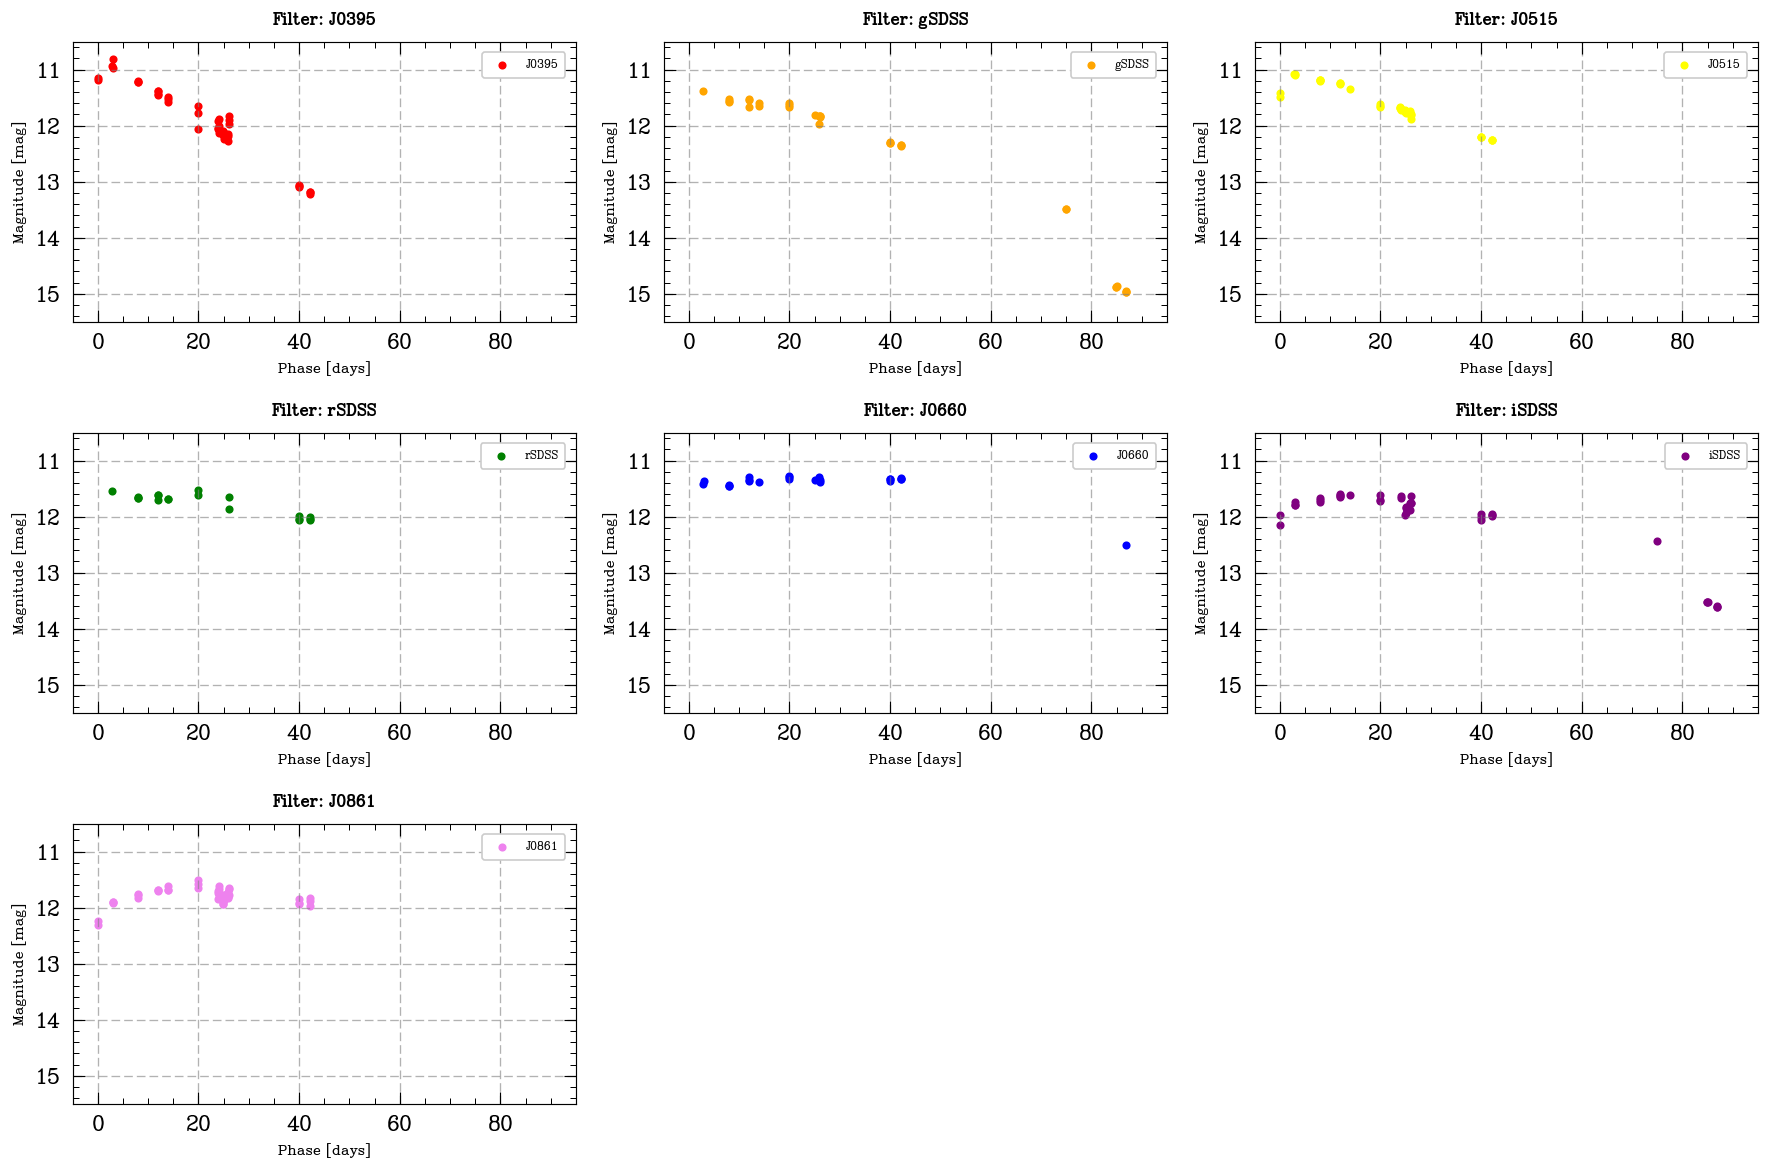

In [14]:
# Define your filters
filters = ['J0395', 'gSDSS', 'J0515', 'rSDSS', 'J0660', 'iSDSS', 'J0861']

# Determine the layout of subplots
num_filters = len(filters)
cols = 3  # Number of columns for the subplot grid
rows = (num_filters + cols - 1) // cols  # Compute the number of rows needed

plt.figure(figsize=(15, 10))

for i, filt in enumerate(filters):
    plt.subplot(rows, cols, i + 1)
    
    mag_column = f'MAG_{filt}'
    magerr_column = f'MAGERR_{filt}'
    year_column = 'OBSDATE'
    
    if mag_column in SN2023ixf.colnames and magerr_column in SN2023ixf.colnames and year_column in SN2023ixf.colnames:
        # Extract data (magnitudes, errors of magnitudes and date)
        mag = SN2023ixf[mag_column]
        e_mag = SN2023ixf[magerr_column]
        years = SN2023ixf[year_column]
        
        # Convert decimal years to days since the first record
        days_since_start = (years - years[0]) * 365.25  

        # Plot
        plt.scatter(days_since_start, mag, s=15, color=color_dict[filt], label=filt)

        # Plot Configuration
        plt.xlabel('Phase [days]', fontsize=10)
        plt.ylabel('Magnitude [mag]', fontsize=10)
        plt.title(f'Filter: {filt}', fontsize=12, fontweight='bold')
        plt.ylim(10.5, 15.5)
        plt.xlim(-5,95)
        plt.grid(True)
        plt.gca().invert_yaxis()
        plt.legend(fontsize=8, frameon=True)

plt.tight_layout()
plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/light_curve_panel_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

### 4.2. Fit - lmfit

We fit, using `lmfit` package the points obtained in the last plot and obtain its characteristical parameters. 

Error fitting data for filter iSDSS: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.


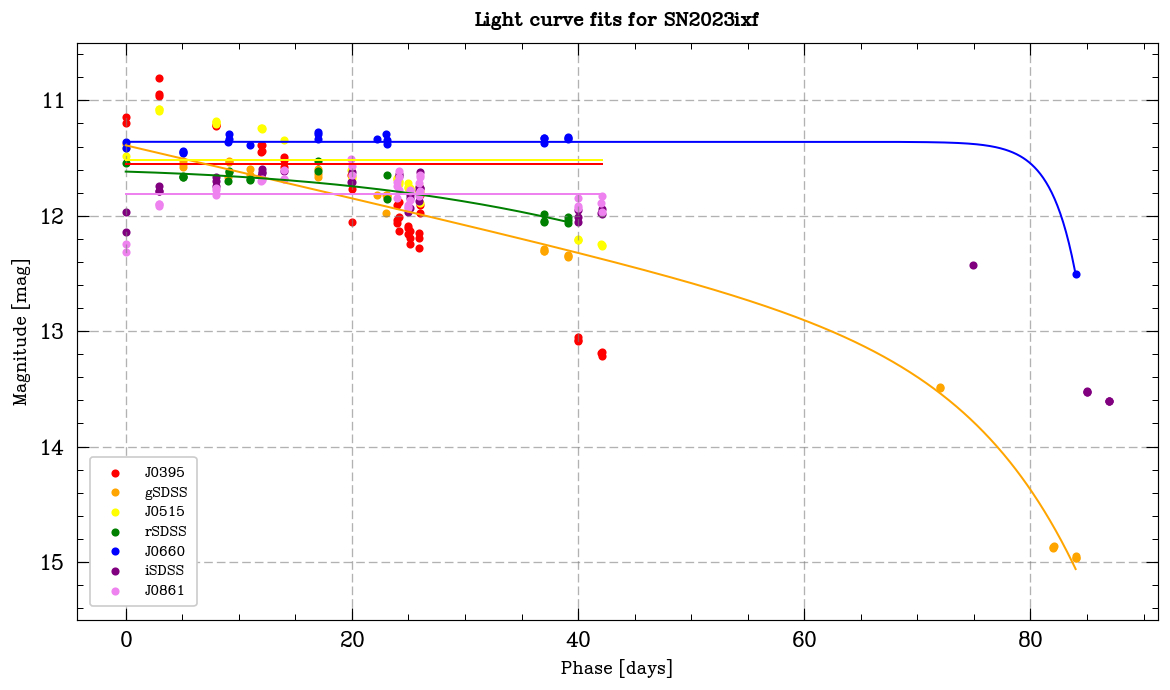

In [15]:
# Bazin Function
def light_curve(t, A, B, tau_fall, tau_rise, t_0):
    return A * (np.exp(-(t - t_0) / tau_fall)) / (1 + np.exp((t - t_0) / tau_rise)) + B

# Model
model = Model(light_curve)

# Figure
plt.figure(figsize=(10, 6))

for filt in filters_JVAR:
    mag_column = f'MAG_{filt}'
    magerr_column = f'MAGERR_{filt}'
    year_column = 'OBSDATE'
    
    if mag_column in SN2023ixf.colnames and magerr_column in SN2023ixf.colnames and year_column in SN2023ixf.colnames:
        # Extract data (magnitudes, errors of magnitudes and data)
        mag = SN2023ixf[mag_column]
        e_mag = SN2023ixf[magerr_column]
        years = SN2023ixf[year_column]
        
        # Filter NaN days
        mask = ~np.isnan(mag) & ~np.isnan(e_mag)
        mag = mag[mask]
        e_mag = e_mag[mask]
        years = years[mask]
        
        # Convert decimal years to days
        days_since_start = (years - years[0]) * 365.25
        
        # Initial conditions
        params = Parameters()
        params.add('A', value=1)
        params.add('B', value=1)
        params.add('tau_fall', value=1)
        params.add('tau_rise', value=1)
        params.add('t_0', value=1)
        
        # Fit data to model
        try:
            result = model.fit(mag, params, t=days_since_start, weights=1/e_mag)
            
            # Extract parameters and each errors
            params_fit = result.params
            errors = {key: value.stderr for key, value in params_fit.items()}
            
            # Function to obtain error bands
            def get_error_bands(params, x, errors, model_func):
                y_fit = model_func(x, **params)
                y_errs = {k: v * np.abs(y_fit) for k, v in errors.items()}
                return y_fit - y_errs['A'], y_fit + y_errs['A']
            
            # Fit and errores
            x_fit = np.linspace(min(days_since_start), max(days_since_start), 1000)
            y_fit = light_curve(x_fit, **result.params.valuesdict())
            #y_lower, y_upper = get_error_bands(result.params.valuesdict(), x_fit, errors, light_curve)
            
            # Plot
            plt.scatter(days_since_start, mag, s=15, color=color_dict[filt], label=f'{filt}')
            plt.plot(x_fit, y_fit, color=color_dict[filt], linestyle='-')
            #plt.fill_between(x_fit, y_lower, y_upper, color=color_dict[filt], alpha=0.2)
        
        except Exception as e:
            print(f'Error fitting data for filter {filt}: {e}')
            plt.scatter(days_since_start, mag, s=15, color=color_dict[filt], label=f'{filt}')

# Plot Configuration
plt.xlabel('Phase [days]', fontsize=12)
plt.ylabel('Magnitude [mag]', fontsize=12)
plt.title('Light curve fits for SN2023ixf', fontsize=14, fontweight='bold')
plt.ylim(10.5, 15.5)
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend(fontsize=10, frameon=True, loc='best')

plt.tight_layout()
plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/light_curve_fit_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

We make the same plot but for all the filters separated. 

Error fitting data for filter iSDSS: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.


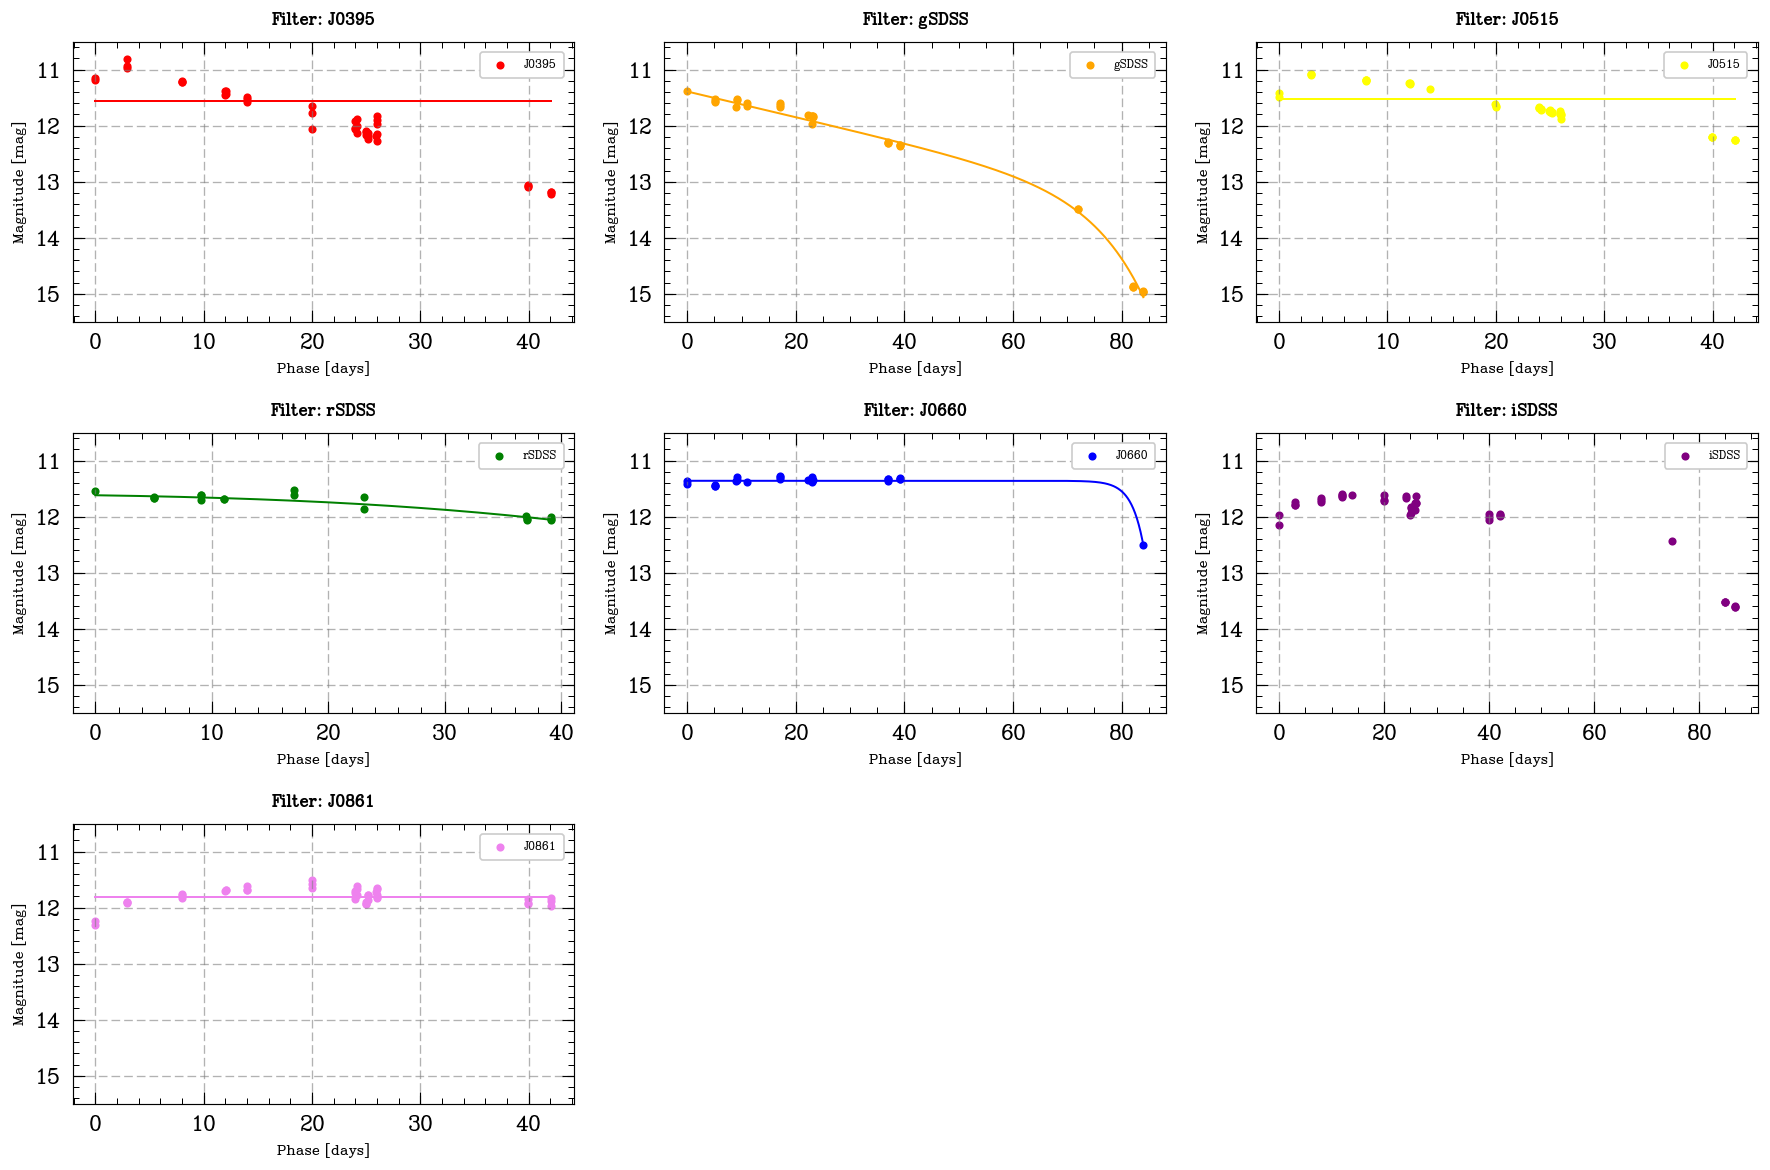

In [16]:
# Bazin Function
def light_curve(t, A, B, tau_fall, tau_rise, t_0):
    return A * (np.exp(-(t - t_0) / tau_fall)) / (1 + np.exp((t - t_0) / tau_rise)) + B

# Model
model = Model(light_curve)

# Subplots
num_filters = len(filters_JVAR)
cols = 3  
rows = (num_filters + cols - 1) // cols  

plt.figure(figsize=(15, 10))

for i, filt in enumerate(filters_JVAR):
    plt.subplot(rows, cols, i + 1)
    
    mag_column = f'MAG_{filt}'
    magerr_column = f'MAGERR_{filt}'
    year_column = 'OBSDATE'
    
    if mag_column in SN2023ixf.colnames and magerr_column in SN2023ixf.colnames and year_column in SN2023ixf.colnames:
        # Extarct data (magnitudes, erros of magnitudes y date)
        mag = SN2023ixf[mag_column]
        e_mag = SN2023ixf[magerr_column]
        years = SN2023ixf[year_column]
        
        # Filter NaN values
        mask = ~np.isnan(mag) & ~np.isnan(e_mag)
        mag = mag[mask]
        e_mag = e_mag[mask]
        years = years[mask]
        
        # COnvert decimal years to days
        days_since_start = (years - years[0]) * 365.25
        
        # Inicial condition and parameters
        params = Parameters()
        params.add('A', value=1)
        params.add('B', value=1)
        params.add('tau_fall', value=1)
        params.add('tau_rise', value=1)
        params.add('t_0', value=1)
        
        # Fit data to model
        try:
            result = model.fit(mag, params, t=days_since_start, weights=1/e_mag)
            
            # Extract parameters and each desviation 
            params_fit = result.params
            errors = {key: value.stderr for key, value in params_fit.items()}
            
            # Function to obtaine errors band
            def get_error_bands(params, x, errors, model_func):
                y_fit = model_func(x, **params)
                y_errs = {k: v * np.abs(y_fit) for k, v in errors.items()}
                return y_fit - y_errs['A'], y_fit + y_errs['A']
            
            # FIt and errors
            x_fit = np.linspace(min(days_since_start), max(days_since_start), 1000)
            y_fit = light_curve(x_fit, **result.params.valuesdict())
            #y_lower, y_upper = get_error_bands(result.params.valuesdict(), x_fit, errors, light_curve)
            
            # Plot
            plt.scatter(days_since_start, mag, s=15, color=color_dict[filt], label=filt)
            plt.plot(x_fit, y_fit, color=color_dict[filt], linestyle='-')
            #plt.fill_between(x_fit, y_lower, y_upper, color=color_dict[filt], alpha=0.2)
        
        except Exception as e:
            print(f'Error fitting data for filter {filt}: {e}')
            plt.scatter(days_since_start, mag, s=15, color=color_dict[filt], label=filt)

        # Plot Configuration
        plt.xlabel('Phase [days]', fontsize=10)
        plt.ylabel('Magnitude [mag]', fontsize=10)
        plt.title(f'Filter: {filt}', fontsize=12, fontweight='bold')
        plt.ylim(10.5, 15.5)
        plt.grid(True)
        plt.gca().invert_yaxis()
        plt.legend(fontsize=8, frameon=True)

plt.tight_layout()
plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/light_curve_fit_panel_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

### 4.3. Fit - sncosmo

We are going to use the package `sncosmo` from Python for the light curves. Specifically, we are going to employ the `nugent-sn2p` model since it is prepared for SN-IIP (the type of SN2023ixf) and its pull is the less one found compared with other SN-IIP models. Besides, the famous `salt2` model cannot be used because it was made for SNIa types. 

Note: We have to transform the magnitudes columns and each error into fluxes assuming a zeropoint (sncosmos need it), that is to say, 

\begin{equation}
    F_1 = 10^{-\frac{(m_1-zp)}{2.5}}\,,
\end{equation}

where _zp_ is the zeropoint chosen, `zp`, and $F_2$ = 1. This methodology is just applied to 'normalize' the fluxes to a low value to reduce the computational effort when calculating the fit with `sncosmo.mcmc_lc`. In other words, it assumes that a flux equivalent to 1 corresponds to a magnitude of `zp` in the AB system. 

In [17]:
# J-VAR bands
wavelength_J0395, transmission_J0395 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0395.dat', unpack=True)
J0395_band = sncosmo.Bandpass(wavelength_J0395, transmission_J0395, name='J0395')
sncosmo.registry.register(J0395_band, force=True)

wavelength_J0515, transmission_J0515 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0515.dat', unpack=True)
J0515_band = sncosmo.Bandpass(wavelength_J0515, transmission_J0515, name='J0515')
sncosmo.registry.register(J0515_band, force=True)

wavelength_J0660, transmission_J0660 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0660.dat', unpack=True)
J0660_band = sncosmo.Bandpass(wavelength_J0660, transmission_J0660, name='J0660')
sncosmo.registry.register(J0660_band, force=True)

wavelength_J0861, transmission_J0861 = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.J0861.dat', unpack=True)
J0861_band = sncosmo.Bandpass(wavelength_J0861, transmission_J0861, name='J0861')
sncosmo.registry.register(J0861_band, force=True)

wavelength_gsdss, transmission_gsdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.gSDSS.dat', unpack=True)
gsdss_band = sncosmo.Bandpass(wavelength_gsdss, transmission_gsdss, name='gsdss')
sncosmo.registry.register(gsdss_band, force=True)

wavelength_rsdss, transmission_rsdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.rSDSS.dat', unpack=True)
rsdss_band = sncosmo.Bandpass(wavelength_rsdss, transmission_rsdss, name='rsdss')
sncosmo.registry.register(rsdss_band, force=True)

wavelength_isdss, transmission_isdss = np.loadtxt('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Filters/OAJ_JPLUS.iSDSS.dat', unpack=True)
isdss_band = sncosmo.Bandpass(wavelength_isdss, transmission_isdss, name='isdss')
sncosmo.registry.register(isdss_band, force=True)

# Functions to convert from decimal years to year/month/day/hour/min
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    fractional_year = decimal_year - year
    
    days_in_year = 365.25
    day_of_year = int(fractional_year * days_in_year)
    
    start_date = datetime(year, 1, 1)
    date = start_date + timedelta(days=day_of_year)
    
    return date

# Function to convert from year/month/day/hour/min to julian date
def date_to_julian_date(date):
    jd = jdcal.gcal2jd(date.year, date.month, date.day)
    return jd[1] + 2400000.5

In the variable `SN2023ixf_sncosmo_ok` we collect all the light curves of all filters, omitting NaNs.

In [18]:
filters_JVAR

['J0395', 'gSDSS', 'J0515', 'rSDSS', 'J0660', 'iSDSS', 'J0861']

In [19]:
# Create SN2023ixf_sncosmo (table that collects light curves in all filters)
jd_obsdates = []
for i in range(len(SN2023ixf['OBSDATE'])):

    jd_obsdate = date_to_julian_date(decimal_year_to_date(SN2023ixf['OBSDATE'][i]))
    jd_obsdates.append(jd_obsdate)

# zp
zp_bands = [20.501, 23.688, 21.640, 23.704, 21.640, 23.384, 21.675]

# Data Table (adding interesting columns)
SN2023ixf_sncosmo = Table()

for filter_name, zp_bands in zip(filters_JVAR, zp_bands):
    mag_column = f'MAG_{filter_name}'
    magerr_column = f'MAGERR_{filter_name}'

    # zp
    zp = 10.00
    
    # Convert magnitudes to fluxes
    flux = 10**(-0.4 * (SN2023ixf[mag_column] - zp))
    fluxerr = flux * np.log(10) * 0.4 * SN2023ixf[magerr_column]
    
    # Create a temporary table for this filter
    temp_table = Table()
    temp_table['time'] = jd_obsdates
    temp_table['band'] = filter_name
    temp_table['flux'] = flux
    temp_table['fluxerr'] = fluxerr
    temp_table['zp'] = zp_bands
    temp_table['zpsys'] = 'ab'
    
    # Append the temporary table to the main table
    if len(SN2023ixf_sncosmo) == 0:
        SN2023ixf_sncosmo = temp_table
    else:
        SN2023ixf_sncosmo = vstack([SN2023ixf_sncosmo, temp_table])

# Filter NaN in SN2023ixf_sncosmo
aa = np.unique(SN2023ixf_sncosmo)
table = Table(aa)

mask = np.ones(len(table), dtype=bool)

for col in table.colnames:

    if np.issubdtype(table[col].dtype, np.floating):
        mask &= ~np.isnan(table[col])

SN2023ixf_sncosmo_ok = table[mask]
SN2023ixf_sncosmo_ok

time,band,flux,fluxerr,zp,zpsys
float64,str5,float64,float64,float64,str2
2460085.5,J0395,0.3334511260997053,0.0006479268224259831,20.501,ab
2460085.5,J0395,0.34897646166984286,0.0007207856856592216,20.501,ab
2460085.5,J0515,0.254878923003385,0.00046672151738272533,21.64,ab
2460085.5,J0515,0.27185303303359465,0.0005210518880725539,21.64,ab
2460085.5,J0861,0.11846214644705726,0.0005858790603382553,21.675,ab
2460085.5,J0861,0.12668111239550225,0.00017166454740953917,21.675,ab
...,...,...,...,...,...
2460172.5,J0660,0.09957118125156138,0.00020776359904856522,21.64,ab
2460172.5,gSDSS,0.010334436574267136,5.224235970201654e-05,23.688,ab


We fit the light curves using `sncosmo.mcmc_lc`. 

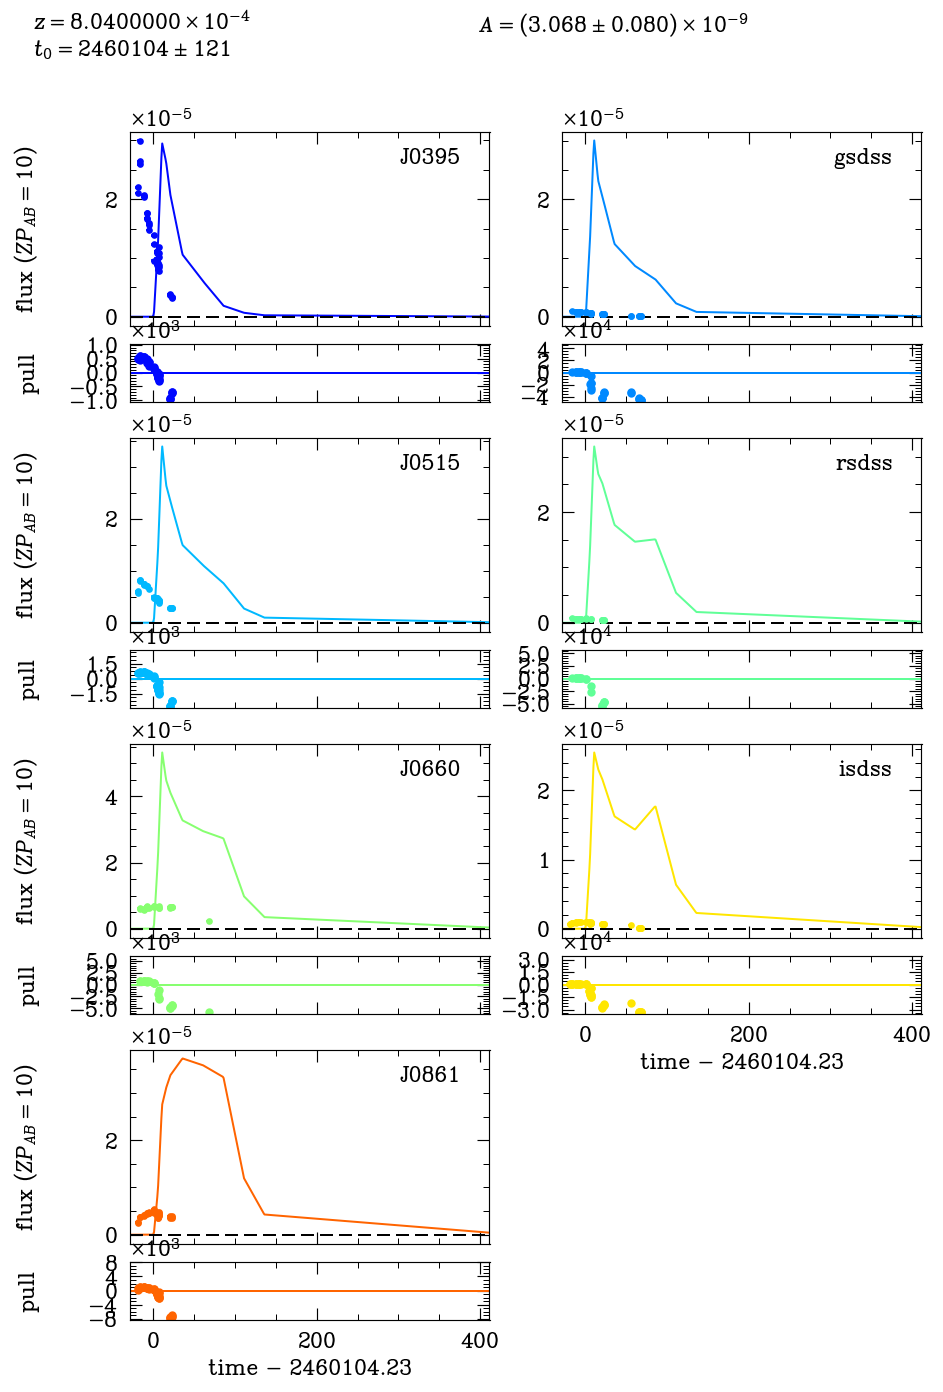

In [20]:
# Model
model = sncosmo.Model(source='nugent-sn2p') 
model.set(z=0.000804)

# sncosmo model
bounds = {  
    't0': (0, 1e6),  
    'amplitude': (1e-12, 1e-6)
}

result, fitted_model = sncosmo.mcmc_lc(SN2023ixf_sncosmo_ok, model, ['t0', 'amplitude'], bounds=bounds,
                                      nwalkers=10, nburn=1000, nsamples=2000, thin=5, minsnr=5) # mcmc_lc or fit_lc

# Plot Light Curves with sncosmo
sncosmo.plot_lc(SN2023ixf_sncosmo_ok, model=fitted_model, errors=result.errors, zp=10, zpsys='ab')

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/sncosmofit_light_curve_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

### 4.4. Colour variation

Lastly, we will plot the change in colour versus the time to see if it gets redder or bluer. For this, we are going to use g-r colour.

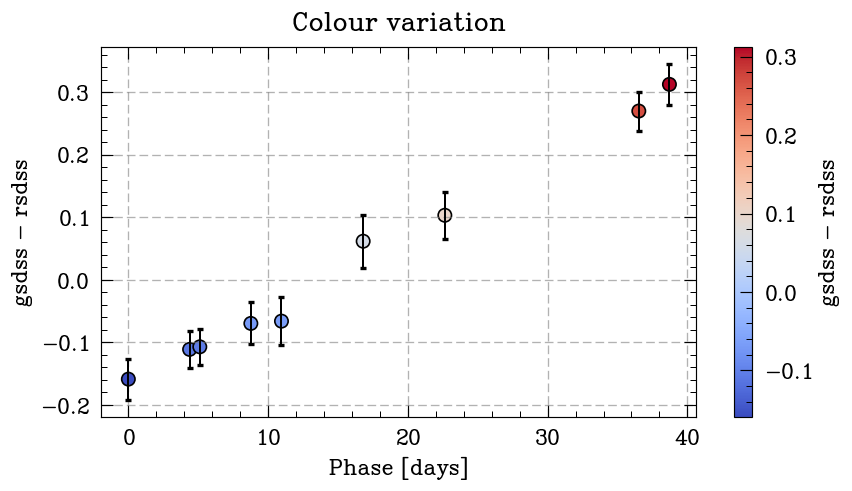

In [21]:
# Date interval
interval = 0.002

# Round dates
SN2023ixf_colvar = SN2023ixf
SN2023ixf_colvar['OBSDATE_ROUND'] = np.round(SN2023ixf_colvar['OBSDATE'] / interval) * interval

# Create grouped table
grouped_table = Table(names=('OBSDATE_ROUND', 'MAG_gSDSS', 'MAGERR_gSDSS', 'MAG_rSDSS', 'MAGERR_rSDSS'), 
                      dtype=('float64', 'float64', 'float64', 'float64', 'float64'))

# Grouped dates
unique_dates = np.unique(SN2023ixf_colvar['OBSDATE_ROUND'])

for date in unique_dates:
    subset = SN2023ixf_colvar[SN2023ixf_colvar['OBSDATE_ROUND'] == date]
    mean_J0395 = np.nanmean(subset['MAG_gSDSS'])
    mean_err_J0395 = np.nanmean(subset['MAGERR_gSDSS'])
    mean_J0861 = np.nanmean(subset['MAG_rSDSS'])
    mean_err_J0861 = np.nanmean(subset['MAGERR_rSDSS'])
    
    grouped_table.add_row([date, mean_J0395, mean_err_J0395, mean_J0861, mean_err_J0861])

# Omit NaN
grouped_table = grouped_table[~np.isnan(grouped_table['MAG_gSDSS'])]
grouped_table = grouped_table[~np.isnan(grouped_table['MAG_rSDSS'])]

# J0395 - J0861
grouped_table['MAG_DIFF'] = grouped_table['MAG_gSDSS'] - grouped_table['MAG_rSDSS']
grouped_table['MAGERR_DIFF'] = np.sqrt((grouped_table['MAGERR_gSDSS'])**2 + (grouped_table['MAGERR_rSDSS']))

# Plot
plt.figure(figsize=(8, 4))
date = (grouped_table['OBSDATE_ROUND'] - grouped_table['OBSDATE_ROUND'][0]) * 365.25
sc = plt.scatter(date, grouped_table['MAG_DIFF'], c=grouped_table['MAG_DIFF'], cmap='coolwarm', edgecolor='k')
plt.errorbar(date, grouped_table['MAG_DIFF'], 
             yerr=grouped_table['MAGERR_DIFF'], fmt='none', ecolor='k', capthick=2)
plt.xlabel('Phase [days]')
plt.ylabel('gsdss - rsdss')
plt.title('Colour variation')
plt.grid(True)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('gsdss - rsdss')

#plt.savefig('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Figures/color_variation_SN2023ixf_JVAR.pdf', dpi=600, bbox_inches='tight')
plt.show()

## Appendix A: Comparison between my offsets and Ale's offsets

In this appendix, we will verify that our offsets are quite similar to the offset reported by Alessandro (`Ale_offsets`).

In [22]:
# Path
file_path = '/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Other/1000002 - J-VAR.csv'

# Ale offsets
Ale_offsets = Table.read(file_path, format='csv', delimiter = ',')
Ale_offsets[0:3]

"﻿""Name""",Telescope,Instrument,Object,Status,QF,RA,DEC,Filter,FWHM (arcsec),σ(FWHM),Obs. date,Image type,Exposition time (s),Air Mass,Raw image name,Calibration,Quality comments,Publication date,Datasum,Checksum,Reduction version,Master frames
str27,str7,str6,str19,str5,str1,float64,float64,str5,float64,float64,str19,str4,int64,float64,str22,str173,int64,str19,int64,str32,str3,str250
j02-20220608T214019-01_proc,OAJ-T80,T80Cam,JVAR02433epoch01,Final,-,211.11188,54.1133,J0395,1.677,0.05,2022/06/08 21:40:19,SCIE,87,1.03802001,j02-20220608T214019-01,-,--,2023/06/04 10:05:36,560820240,db79eb5a28ce38d7b5c423c1a2ec8f23,C01,"'ICOR name:',j02-ICOR-b20220519e0610-J0395-00-C01PF205D64-1,'FLAT name:',j02-FLAS-b20220519e0610-J0395-00-C01M5,'OVSC name:',j02-OVSC-b20220204e0112-50s601s-00-C01M5XO54P0YO27P27,'Bad pixels in HOTPIX mask:',33955,'Bad pixels in COLDPIX mask:',48321,"
j02-20220608T214214-01_proc,OAJ-T80,T80Cam,JVAR02433epoch01,Final,-,211.11186,54.1133,gSDSS,1.304,0.024,2022/06/08 21:42:14,SCIE,33,1.03857994,j02-20220608T214214-01,-,--,2023/06/04 10:05:36,3864115466,e3ae79ae72575644f6da4c3715eb5b1f,C01,"'ICOR name:',j02-ICOR-b20220519e0610-gSDSS-00-C01PF205D64-1,'FLAT name:',j02-FLAS-b20220519e0610-gSDSS-00-C01M5,'OVSC name:',j02-OVSC-b20220204e0112-20s50s-00-C01M5XO54P0YO27P27,'Bad pixels in HOTPIX mask:',33955,'Bad pixels in COLDPIX mask:',39672,"
j02-20220608T214322-01_proc,OAJ-T80,T80Cam,JVAR02433epoch01,Final,-,211.11182,54.11329,J0515,1.51,0.047,2022/06/08 21:43:22,SCIE,40,1.03904998,j02-20220608T214322-01,-,--,2023/06/04 10:05:36,1783313312,9526a7a5c48a2655956b2c1a50941255,C01,"'ICOR name:',j02-ICOR-b20220519e0610-J0515-00-C01PF205D64-1,'FLAT name:',j02-FLAS-b20220519e0610-J0515-00-C01M5,'OVSC name:',j02-OVSC-b20220204e0112-20s50s-00-C01M5XO54P0YO27P27,'Bad pixels in HOTPIX mask:',33955,'Bad pixels in COLDPIX mask:',40341,"


## Appendix B: Zero-points for each JVAR filter

To complete the PESSTO work correctly, we added this appendix to calculate the zero-points (ZPs) for each J-VAR filter.

In [23]:
# JPLUS tiles
JPLUS_tiles = Table.read('/media/juanan/JUANAN/Juanan/AstroWork/Intern CEFCA/Data/Other/JPLUS_tiles.fits', format = 'fits')
JPLUS_tiles = JPLUS_tiles['TILE_ID', 'RA', 'DEC', 'ZPT', 'FILTER_ID']
JPLUS_tiles

TILE_ID,RA,DEC,ZPT,FILTER_ID
int32,float64,float64,float32,int32
85282,144.7648,27.6581,20.6417,6
88565,155.2496,36.0123,20.354,7
87471,186.6046,33.2276,23.6988,2
86377,105.8119,31.8352,22.8566,4
90788,268.0,40.1895,21.4406,8
91894,273.1293,42.9742,20.262,7
...,...,...,...,...
103944,42.409,-3.6962,23.6068,1
104001,244.3132,44.3666,23.4689,1


In [24]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack

# Suppose that AA and BB are astropy tables that we want to match based on their coordinates
AA = JPLUS
BB = JPLUS_tiles

# Convert AA coordinates to SkyCoord 
coords_AA = SkyCoord(ra=AA['ALPHA_J2000']*u.deg, dec=AA['DELTA_J2000']*u.deg)  # change column names if needed 

# Convert BB coordinates to SkyCoord
coords_BB = SkyCoord(ra=BB['RA']*u.deg, dec=BB['DEC']*u.deg)  # change column names if needed

# Cross-match with a given radius
radius = 1.0 * u.degree  # define the matching radius

# Match AA coordinates to BB coordinates
idx_BB, sep2d, _ = coords_BB.match_to_catalog_sky(coords_AA)

# Filter matches within the specified radius
matches = sep2d < radius

# Filter the tables to get only the matched rows
matched_AA = AA[idx_BB[matches]]
matched_BB = BB[matches]

# Combine the matched tables into a single table
combined_table = hstack([matched_AA, matched_BB])
combined_table

NUMBER,TILE_ID_1,ALPHA_J2000,DELTA_J2000,MAG_AUTO,MAG_ERR_AUTO,MAG_APER_0_8,MAG_ERR_APER_0_8,MAG_APER_1_0,MAG_ERR_APER_1_0,MAG_APER_1_2,MAG_ERR_APER_1_2,MAG_APER_1_5,MAG_ERR_APER_1_5,MAG_APER_2_0,MAG_ERR_APER_2_0,MAG_APER_3_0,MAG_ERR_APER_3_0,MAG_APER_COR_3_0,MAG_ERR_APER_COR_3_0,MAG_APER_4_0,MAG_ERR_APER_4_0,MAG_APER_6_0,MAG_ERR_APER_6_0,MAG_APER_COR_6_0,MAG_ERR_APER_COR_6_0,TILE_ID_2,RA,DEC,ZPT,FILTER_ID
int32,int32,float64,float64,float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],float32[12],int32,float64,float64,float32,int32
419,94554,212.2333626684405,53.40633884034106,16.180443 .. 15.951982,0.005301446 .. 0.012301012,17.796095 .. 17.575954,0.014347038 .. 0.026921406,17.431435 .. 17.211832,0.010279835 .. 0.019383412,17.130167 .. 16.911257,0.0084740305 .. 0.016053442,16.819399 .. 16.601269,0.0067303516 .. 0.012872574,16.526995 .. 16.308092,0.005400848 .. 0.010428938,16.32506 .. 16.101357,0.0047878684 .. 0.00953432,16.132961 .. 15.896598,0.0043157083 .. 0.0085237315,16.259094 .. 16.029268,0.004734026 .. 0.009749691,16.204746 .. 15.977523,0.00500324 .. 0.011099903,16.124851 .. 15.894839,0.0046470487 .. 0.010288118,94170,212.2947,52.7209,21.5198,9
419,94554,212.2333626684405,53.40633884034106,16.180443 .. 15.951982,0.005301446 .. 0.012301012,17.796095 .. 17.575954,0.014347038 .. 0.026921406,17.431435 .. 17.211832,0.010279835 .. 0.019383412,17.130167 .. 16.911257,0.0084740305 .. 0.016053442,16.819399 .. 16.601269,0.0067303516 .. 0.012872574,16.526995 .. 16.308092,0.005400848 .. 0.010428938,16.32506 .. 16.101357,0.0047878684 .. 0.00953432,16.132961 .. 15.896598,0.0043157083 .. 0.0085237315,16.259094 .. 16.029268,0.004734026 .. 0.009749691,16.204746 .. 15.977523,0.00500324 .. 0.011099903,16.124851 .. 15.894839,0.0046470487 .. 0.010288118,94171,212.2947,52.7209,21.226,5
419,94554,212.2333626684405,53.40633884034106,16.180443 .. 15.951982,0.005301446 .. 0.012301012,17.796095 .. 17.575954,0.014347038 .. 0.026921406,17.431435 .. 17.211832,0.010279835 .. 0.019383412,17.130167 .. 16.911257,0.0084740305 .. 0.016053442,16.819399 .. 16.601269,0.0067303516 .. 0.012872574,16.526995 .. 16.308092,0.005400848 .. 0.010428938,16.32506 .. 16.101357,0.0047878684 .. 0.00953432,16.132961 .. 15.896598,0.0043157083 .. 0.0085237315,16.259094 .. 16.029268,0.004734026 .. 0.009749691,16.204746 .. 15.977523,0.00500324 .. 0.011099903,16.124851 .. 15.894839,0.0046470487 .. 0.010288118,94172,212.2947,52.7209,21.4561,8
419,94554,212.2333626684405,53.40633884034106,16.180443 .. 15.951982,0.005301446 .. 0.012301012,17.796095 .. 17.575954,0.014347038 .. 0.026921406,17.431435 .. 17.211832,0.010279835 .. 0.019383412,17.130167 .. 16.911257,0.0084740305 .. 0.016053442,16.819399 .. 16.601269,0.0067303516 .. 0.012872574,16.526995 .. 16.308092,0.005400848 .. 0.010428938,16.32506 .. 16.101357,0.0047878684 .. 0.00953432,16.132961 .. 15.896598,0.0043157083 .. 0.0085237315,16.259094 .. 16.029268,0.004734026 .. 0.009749691,16.204746 .. 15.977523,0.00500324 .. 0.011099903,16.124851 .. 15.894839,0.0046470487 .. 0.010288118,94174,212.2947,52.7209,21.6624,10
419,94554,212.2333626684405,53.40633884034106,16.180443 .. 15.951982,0.005301446 .. 0.012301012,17.796095 .. 17.575954,0.014347038 .. 0.026921406,17.431435 .. 17.211832,0.010279835 .. 0.019383412,17.130167 .. 16.911257,0.0084740305 .. 0.016053442,16.819399 .. 16.601269,0.0067303516 .. 0.012872574,16.526995 .. 16.308092,0.005400848 .. 0.010428938,16.32506 .. 16.101357,0.0047878684 .. 0.00953432,16.132961 .. 15.896598,0.0043157083 .. 0.0085237315,16.259094 .. 16.029268,0.004734026 .. 0.009749691,16.204746 .. 15.977523,0.00500324 .. 0.011099903,16.124851 .. 15.894839,0.0046470487 .. 0.010288118,94175,212.2947,52.7209,21.6825,12
419,94554,212.2333626684405,53.40633884034106,16.180443 .. 15.951982,0.005301446 .. 0.012301012,17.79

For each filter (`FILTER_ID`), we estime, by doing an avarage, the zero-point (`ZPT`).

In [25]:
# Group table for FILTER_ID
grouped_table = combined_table.group_by('FILTER_ID')

# Calcualtion of ZP for each filter
filter_ids = []
median_zpts = []

for group in grouped_table.groups:
    filter_id = group['FILTER_ID'][0]
    median_zpt = np.median(group['ZPT'])
    
    filter_ids.append(filter_id)
    median_zpts.append(median_zpt)

# Result
medianas_ZP = Table([filter_ids, median_zpts], names=['FILTER_ID', 'Mediana_ZPT'])

# Filters names
filter_names = {
    1: 'rSDSS',
    2: 'gSDSS',
    3: 'iSDSS',
    4: 'zSDSS',
    5: 'uJAVA',
    6: 'J0378',
    7: 'J0395',
    8: 'J0410',
    9: 'J0430',
    10: 'J0515',
    11: 'J0660',
    12: 'J0861'
}

filter_names_column = [filter_names[fid] for fid in medianas_ZP['FILTER_ID']]
medianas_ZP['Filter_Name'] = filter_names_column
medianas_ZP

FILTER_ID,Mediana_ZPT,Filter_Name
int32,float32,str5
1,23.7042,rSDSS
2,23.688549,gSDSS
3,23.384201,iSDSS
4,22.820301,zSDSS
5,21.1977,uJAVA
6,20.618599,J0378
7,20.5018,J0395
8,21.43075,J0410
9,21.4983,J0430


In [26]:
# Ejectuoon Time
b = time.time()
print(np.round((b-a)/60,2),'min of execution')

2.03 min of execution
